# Capstone - Poisson Model with SPI Data

Since we have already conducted the poisson model with the SPI data from 2016-2020, we can try to see if we get better results from the SPI data alone.

The goal of the model is to achieve an accuracy of >50% in predicting match results since we achieved 49% using the EPL Data only.

The dataset only has 1416 matches stemming from the last 3.5 seasons (2019-2020 has not been completed yet).  It may seem like a smaller set and your intuition might tell you that it is not enough data to train the model.  However, the Premier League only plays 380 matches a year and each season has 3 teams relegated to the second tier while 3 teams get promoted to the second tier.  Therefore, seasons differ tremendously from year to year.  Too much data and our results will be skewed while too little will lead to overfitting.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson, skellam

In [2]:
# We will read in the CSV and remove the unnecessary rows.
pl_df = pd.read_csv('pl_spi.csv')

In [3]:
# Sanity check to ensure the CSV imported properly
pl_df

,Unnamed: 0,Date,HomeTeam,AwayTeam,HomeSPI,AwaySPI,HomeWinProb,AwayWinProb,TieProb,HomeProjScore,...,HomeImportance,AwayImportance,score1,score2,HomeShotXPG,AwayShotXPG,HomeNonShotXPG,AwayNonShotXPG,HomeAdjScore,AwayAdjScore
0,0,2016-08-13,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,1.16,...,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
1,1,2016-08-13,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,1.35,...,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
2,2,2016-08-13,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,1.47,...,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05
3,3,2016-08-13,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,0.2927,1.30,...,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,1.05,1.05
4,4,2016-08-13,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,1.37,...,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.00,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,1411,2020-02-29,Brighton and Hove Albion,Crystal Palace,70.68,68.96,0.5000,0.2327,0.2674,1.50,...,32.1,7.7,0.0,1.0,2.06,2.41,1.80,1.49,0.00,1.05
1412,1412,2020-02-29,Newcastle,Burnley,59.44,70.18,0.3520,0.3679,0.2801,1.21,...,28.3,8.3,0.0,0.0,1.45,0.66,1.11,0.81,0.00,0.00
1413,1414,2020-02-29,West Ham United,Southampton,65.53,71.96,0.4304,0.3190,0.2507,1.59,...,50.3,4.9,3.0,1.0,2.63,0.90,1.15,1.28,3.15,1.05
1414,1415,2020-02-29,AFC Bournemouth,Chelsea,62.54,84.59,0.2047,0.5733,0.2220,1.10,...,66.6,78.8,2.0,2.0,1.55,2.11,1.08,2.61,2.10,2.10


In [4]:
# Drop unwanted columns
pl_df = pl_df.drop(columns = 'Unnamed: 0')

In [5]:
pl_df

,Date,HomeTeam,AwayTeam,HomeSPI,AwaySPI,HomeWinProb,AwayWinProb,TieProb,HomeProjScore,AwayProjScore,HomeImportance,AwayImportance,score1,score2,HomeShotXPG,AwayShotXPG,HomeNonShotXPG,AwayNonShotXPG,HomeAdjScore,AwayAdjScore
0,2016-08-13,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,1.16,1.24,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
1,2016-08-13,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,1.35,1.14,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
2,2016-08-13,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,1.47,1.38,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05
3,2016-08-13,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,0.2927,1.30,1.01,33.9,32.5,1.0,1.0,1.40,0.55,1.13,1.06,1.05,1.05
4,2016-08-13,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,1.37,1.05,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.00,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,2020-02-29,Brighton and Hove Albion,Crystal Palace,70.68,68.96,0.5000,0.2327,0.2674,1.50,0.93,32.1,7.7,0.0,1.0,2.06,2.41,1.80,1.49,0.00,1.05
1412,2020-02-29,Newcastle,Burnley,59.44,70.18,0.3520,0.3679,0.2801,1.21,1.24,28.3,8.3,0.0,0.0,1.45,0.66,1.11,0.81,0.00,0.00
1413,2020-02-29,West Ham United,Southampton,65.53,71.96,0.4304,0.3190,0.2507,1.59,1.34,50.3,4.9,3.0,1.0,2.63,0.90,1.15,1.28,3.15,1.05
1414,2020-02-29,AFC Bournemouth,Chelsea,62.54,84.59,0.2047,0.5733,0.2220,1.10,1.98,66.6,78.8,2.0,2.0,1.55,2.11,1.08,2.61,2.10,2.10


In [6]:
# Train set - we know that each season has 380 games.
pl_train = pl_df[:1338]

pl_train.shape

(1338, 20)

In [7]:
# Test set
pl_test = pl_df[1338:]

pl_test.shape

(78, 20)

In [134]:
pl_test

,Date,HomeTeam,AwayTeam,HomeSPI,AwaySPI,HomeWinProb,AwayWinProb,TieProb,HomeProjScore,AwayProjScore,HomeImportance,AwayImportance,score1,score2,HomeShotXPG,AwayShotXPG,HomeNonShotXPG,AwayNonShotXPG,HomeAdjScore,AwayAdjScore
0,2019-12-29,Manchester City,Sheffield United,94.53,71.91,0.8507,0.0398,0.1095,2.82,0.48,13.6,13.6,2.0,0.0,1.22,1.21,1.27,0.76,1.80,0.00
1,2020-01-01,Burnley,Aston Villa,69.44,61.33,0.4966,0.2524,0.2510,1.65,1.10,27.5,50.8,1.0,2.0,2.49,1.43,2.11,1.35,1.05,2.10
2,2020-01-01,Brighton and Hove Albion,Chelsea,70.31,85.74,0.2215,0.5452,0.2334,1.10,1.85,18.1,66.3,1.0,1.0,1.74,1.39,2.08,1.32,1.05,1.05
3,2020-01-01,Watford,Wolverhampton,69.87,78.66,0.3680,0.3540,0.2780,1.26,1.23,50.6,31.5,2.0,1.0,1.08,1.29,1.53,0.92,2.10,1.05
4,2020-01-01,Southampton,Tottenham Hotspur,68.97,82.24,0.2711,0.4950,0.2339,1.31,1.84,26.2,52.0,1.0,0.0,1.31,1.18,1.14,1.25,1.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2020-02-29,Brighton and Hove Albion,Crystal Palace,70.68,68.96,0.5000,0.2327,0.2674,1.50,0.93,32.1,7.7,0.0,1.0,2.06,2.41,1.80,1.49,0.00,1.05
74,2020-02-29,Newcastle,Burnley,59.44,70.18,0.3520,0.3679,0.2801,1.21,1.24,28.3,8.3,0.0,0.0,1.45,0.66,1.11,0.81,0.00,0.00
75,2020-02-29,West Ham United,Southampton,65.53,71.96,0.4304,0.3190,0.2507,1.59,1.34,50.3,4.9,3.0,1.0,2.63,0.90,1.15,1.28,3.15,1.05
76,2020-02-29,AFC Bournemouth,Chelsea,62.54,84.59,0.2047,0.5733,0.2220,1.10,1.98,66.6,78.8,2.0,2.0,1.55,2.11,1.08,2.61,2.10,2.10


### LEGEND

Now that we have our final data table, a legend is provided to help the user understand what each feature represents

- **Date**: Match Date
- **HomeTeam**: Name of the Home Team
- **AwayTeam**: Name of the Away Team
- **HomeSPI**: Soccer Power Index for the Home Team
- **AwaySPI**: Soccer Power Index for the Away Team
- **HomeWinProb**: Calculated probability of a Home Win
- **AwayWinProb**: Calculated probability of an Away Win
- **TieProb**: Calculated probability of a draw between the Home and Away Team
- **HomeProjScore**: Projected number of goals scored by the Home Team
- **AwayProjScore**: Projected number of goals scored by the Away Team
- **HomeImportance**: Importance of a win for the Home Team
- **AwayImportance**: Importance of a win for the Away Team
- **score1**: Number of goals scored by the Home Team at Full Time
- **score2**: Number of goals scored by the Away Team at Full Time
- **HomeShotXPG**: Expected goals based on how many goals the Home Team should have scored, given the shots they took.  Probability is assigned based on distance, angle from the goal, what part of the body the shot was taken with and who took the shot.  The individual shot probabilities are added together to produce this metric which may be larger or smaller than the actual goals scored in the match.
- **AwayShotXPG**: Expected goals based on how many goals the Away Team should have scored, given the shots they took.
- **HomeNonShotXPG**: Non-shot expected goals based on how many goals the home team should have scored dependent on non-shooting actions around the opposition: passes, interceptions, take-ons, tackles.  For example, a completed pass received at the center of the six-yard box leads to a 14% chance of a goal.  The actions added up through the entire match to arrive at this metric and just as the Shot XPG, each action is adjusted based on on the success rate of the player(s).
- **AwayNonShotXPG**: Non-shot expected goals based on how many goals the away team should have scored dependent on non-shooting actions around the opposition: passes, interceptions, take-ons, tackles
- **HomeAdjScore**: Adjusted goals is the value of goals scored for the Home team when a team has more players on the field or late goals if the home team is leading.  Once the goals are downweighted, the value of all other goals are increased to make the total adjusted goals add up as close as possible to the total number of goals scored by the Home Team.
- **AwayAdjScore**: Adjusted goals for the away team.  Calculated similarly to the Home Adjusted Goals Scored.

# EDA

Now that we have our dataset tailor-made for the Poisson Distribution, we can begin to code our model.  As previously discussed, the poisson distribution states that we can calculate the probability of goals scored within a specific time period against the average rate of occurence in which the goals are scored.  We assume that the goals scored are independent of time, that is to say that the outcomes of goals scored do not depend on goals that have already been scored in a match. The mathematical function is as follows:

$$ \begin{align}
P(k) &=  \frac{e^{-λ}λ^k}{k!},  k >0 \\
\end{align}$$

Where P(k) is the probability of the event occurring (in this case goals scored), λ is the average goals scored, and k is the number of occurence (e.g. k = 1, means 1 goal scored).

In [8]:
# We first need to find the means for the goals scored for the home and away team

pl_df.mean()

HomeSPI           68.727888
AwaySPI           68.665805
HomeWinProb        0.457728
AwayWinProb        0.307887
TieProb            0.234388
HomeProjScore      1.602500
AwayProjScore      1.218489
HomeImportance    34.780226
AwayImportance    33.402472
score1             1.553672
score2             1.209040
HomeShotXPG        1.570042
AwayShotXPG        1.247133
HomeNonShotXPG     1.591963
AwayNonShotXPG     1.299061
HomeAdjScore       1.557973
AwayAdjScore       1.220819
dtype: float64

We see that on average, the home team scores a higher proportion of goals per game than the away team.  Home advantage clearly plays a role in performance output across many if not all the features.

Average Home Team Goals scored: **1.55** Goals per Match

Average Away Team Goals scored: **1.21** Goals per Match

These averages will be represented as λ in our poisson distribution.

We can check the number of goals scored per Match over the entire dataframe to get a skellam distribution which plots the two independent poisson distributions (home and away).

In [9]:
# First we need to take the proportion matches for each final home team score per match
fthg_pro = (pl_df['score1'].value_counts())/len(pl_df)

fthg_pro

1.0    0.322034
2.0    0.247175
0.0    0.224576
3.0    0.122881
4.0    0.055791
5.0    0.021893
6.0    0.004237
8.0    0.000706
7.0    0.000706
Name: score1, dtype: float64

In [10]:
# Second we will do the same for the away team
ftag_pro = (pl_df['score2'].value_counts())/len(pl_df)

ftag_pro

0.0    0.331921
1.0    0.329096
2.0    0.205508
3.0    0.085452
4.0    0.034605
5.0    0.009181
6.0    0.002825
9.0    0.000706
7.0    0.000706
Name: score2, dtype: float64

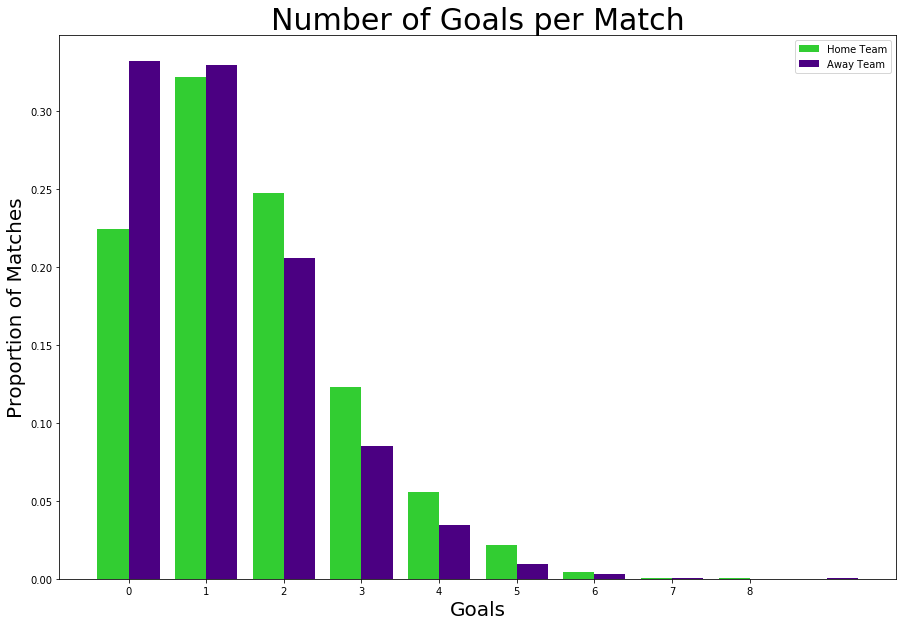

In [11]:
width = 0.4

fig, ax = plt.subplots(figsize = [15, 10])
Home = ax.bar(fthg_pro.index - width/2, fthg_pro.values, width, label = 'Home Team', color = 'limegreen')
Away = ax.bar(ftag_pro.index + width/2, ftag_pro.values, width, label = 'Away Team', color = 'indigo')
ax.set_ylabel('Proportion of Matches', fontsize = 20)
ax.set_xlabel('Goals', fontsize = 20)
ax.set_title('Number of Goals per Match', fontsize = 30)
ax.set_xticks(fthg_pro.index)
ax.legend()
plt.show()

Now that we have the actual goals scored per match, we can add the poisson distribution of the goals scored per
match to see if the plot follows this distribution.  If it does, we have visual evidence that we can use a Poisson
Regression to predict the match outcome probabilities.

In [12]:
# Instantiate the two final goals tally for the home and away team from pl_df.  This will be used in the for loop
gpm = pl_df[['score1', 'score2']] # GPM = Goals per Match

gpm

,score1,score2
0,2.0,1.0
1,0.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,1.0
...,...,...
1411,0.0,1.0
1412,0.0,0.0
1413,3.0,1.0
1414,2.0,2.0


In [13]:
gpm.mean() # sanity check

score1    1.553672
score2    1.209040
dtype: float64

In [14]:
# Calculate the poisson distribution using a for loop that will cycle through the means

fthg_values = []
ftag_values = []

for g in range(10):
        # Calculate the poisson distribution for the home team
        fthg_poisson = poisson.pmf(g, gpm.mean()[0])
        # Calculate the poisson distribution for the away team
        ftag_poisson = poisson.pmf(g, gpm.mean()[1])
        
        # Append the fthg values to a list
        fthg_values.append(fthg_poisson)
        
        # Append the ftag values to a list
        ftag_values.append(ftag_poisson)
        

In [15]:
# Sanity Check
print(fthg_values)

print(ftag_values)

[0.21146996154292835, 0.32855502499607514, 0.25523342337265725, 0.13218303470335355, 0.051342280428562447, 0.015953815952378173, 0.004131167030983046, 0.000916925692913913, 0.00017807525815771624, 3.07411776480678e-05]
[0.29848382117933925, 0.3608787442507266, 0.21815833691993072, 0.08792068568901162, 0.026574896521819893, 0.006426020175897697, 0.001294885421508575, 0.00022365252639453996, 3.380059367827086e-05, 4.540694944852462e-06]


In [16]:
# Now we have to concatenate them into an 2-D array

poisson_values = pd.DataFrame(np.column_stack([fthg_values, ftag_values]))

poisson_values = poisson_values.rename(columns = {0:'Home Poisson Vals', 1:'Away Poisson Vals'})

poisson_values

,Home Poisson Vals,Away Poisson Vals
0,0.211470,0.298484
1,0.328555,0.360879
2,0.255233,0.218158
3,0.132183,0.087921
4,0.051342,0.026575
5,0.015954,0.006426
6,0.004131,0.001295
7,0.000917,0.000224
8,0.000178,0.000034
9,0.000031,0.000005


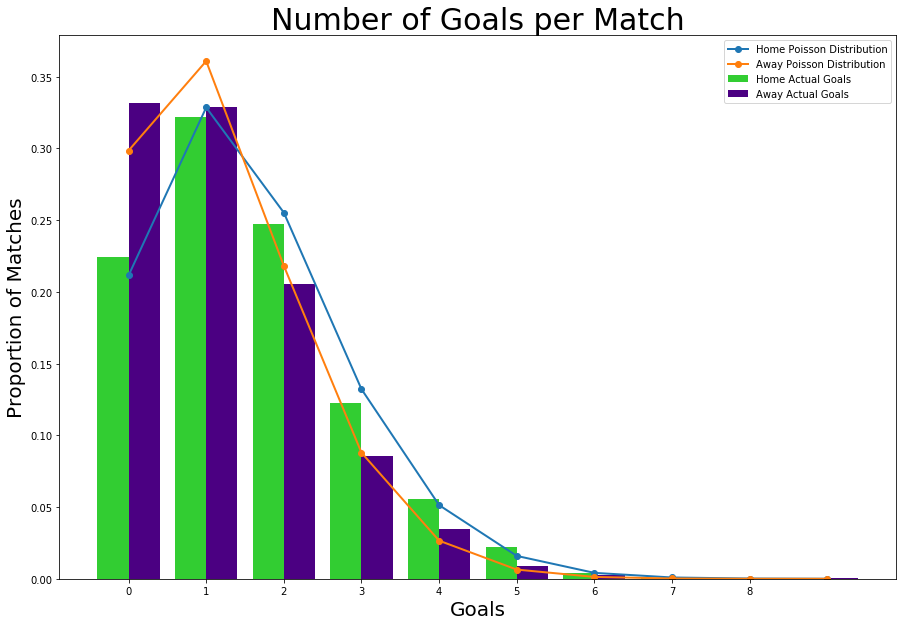

In [17]:
# We copy the same plot from above

# Add the following parameters
width = 0.4 # Determine width of the columns

fig, ax = plt.subplots(figsize = [15, 10])
# Plot the actual goals per proportion of matches
Home = ax.bar(fthg_pro.index - width/2, fthg_pro.values, width, label = 'Home Actual Goals', color = 'limegreen')
Away = ax.bar(ftag_pro.index + width/2, ftag_pro.values, width, label = 'Away Actual Goals', color = 'indigo')

# Plot the poisson values calculated above
FTHG_poisson_vals = ax.plot(poisson_values.index, poisson_values.iloc[:,0], marker = 'o', linewidth = 2,\
                            label = 'Home Poisson Distribution')
FTHG_poisson_vals = ax.plot(poisson_values.index, poisson_values.iloc[:,1], marker = 'o', linewidth = 2,\
                            label = 'Away Poisson Distribution')

ax.set_ylabel('Proportion of Matches', fontsize = 20)
ax.set_xlabel('Goals', fontsize = 20)
ax.set_title('Number of Goals per Match', fontsize = 30)
ax.set_xticks(fthg_pro.index)
ax.legend()
plt.show()

The plot generated above is consistent with the pattern seen in Poisson Distributions so we can move ahead with modelling using a Poisson Regression.  Football is typically a low scoring match and a higher number of goals scored per match is less likely to occur.  This is consistent with what is displayed in the plot and is further demonstrated when we ran the Poisson Distribution.

Further assumptions:
- Each goal scored is seen as an independent event from one another (i.e. a team scoring a goal does not lead to more goals being scored.  If that was the case, then we would see a right skewed distribution).
- We only know the average rate of goals scored and is independent of any occurrence.
- Goals from the home and away side cannot occur in the same instance.
- The Poisson Distribution is an **estimate** of the number of goals scored for both sides from 2016-2019.

We can provide further evidence to conduct a poisson regression by looking at the Skellam Distribution which is typical of poisson-distributed values.  The Skellam distribution is the difference between the two means for each goal scored in our dataset.  We will calculate the skellam probability mass function (pmf) as we did in the Poisson Distribution for each goal scored and their respective home and away means.  The Skellam distribution will show an convolution of the two poisson distributions calculated above into a binomial distribution.

In [18]:
skellam_vals = []

for g in range(-6, 7):
    skel_dist = skellam.pmf(g, gpm.mean()[0], gpm.mean()[1])
    
    skellam_vals.append(skel_dist)
    
skellam_vals_df = pd.DataFrame(skellam_vals, range(-6,7))

skellam_vals_df = skellam_vals_df.reset_index()

skellam_vals_df = skellam_vals_df.rename(columns = {'index':'GD', 0:'Skellam'})

skellam_vals_df = skellam_vals_df.set_index('GD', drop = True)

In [19]:
skellam_vals_df

,Skellam
GD,
-6,0.000357
-5,0.001846
-4,0.008093
-3,0.029147
-2,0.082723
-1,0.174297
0,0.250464
1,0.223979
2,0.136604


In [20]:
gd_pro = ((pl_df['score1']-pl_df['score2']).value_counts())/len(pl_df)

gd_pro = gd_pro.reset_index()

gd_pro = gd_pro.rename(columns = {'index':'GD', 0:'Proportion of Matches'})

gd_pro = gd_pro.sort_values(by = ['GD'])

gd_pro = gd_pro.set_index('GD', drop = True)

gd_pro

,Proportion of Matches
GD,
-9.0,0.000706
-6.0,0.001412
-5.0,0.004237
-4.0,0.019774
-3.0,0.043785
-2.0,0.080508
-1.0,0.153249
0.0,0.228107
1.0,0.205508


In [21]:
# We can merge gd_pro into the skellam_values_df dataframe to make it easier to plot

plot_values = gd_pro.merge(skellam_vals_df, left_index = True, right_index = True)

plot_values = plot_values.rename(columns = {0:'Skellam'})

plot_values = plot_values.sort_values(by = ['GD'])

plot_values = plot_values.reset_index()

In [22]:
plot_values

,GD,Proportion of Matches,Skellam
0,-6,0.001412,0.000357
1,-5,0.004237,0.001846
2,-4,0.019774,0.008093
3,-3,0.043785,0.029147
4,-2,0.080508,0.082723
5,-1,0.153249,0.174297
6,0,0.228107,0.250464
7,1,0.205508,0.223979
8,2,0.156073,0.136604
9,3,0.060028,0.061852


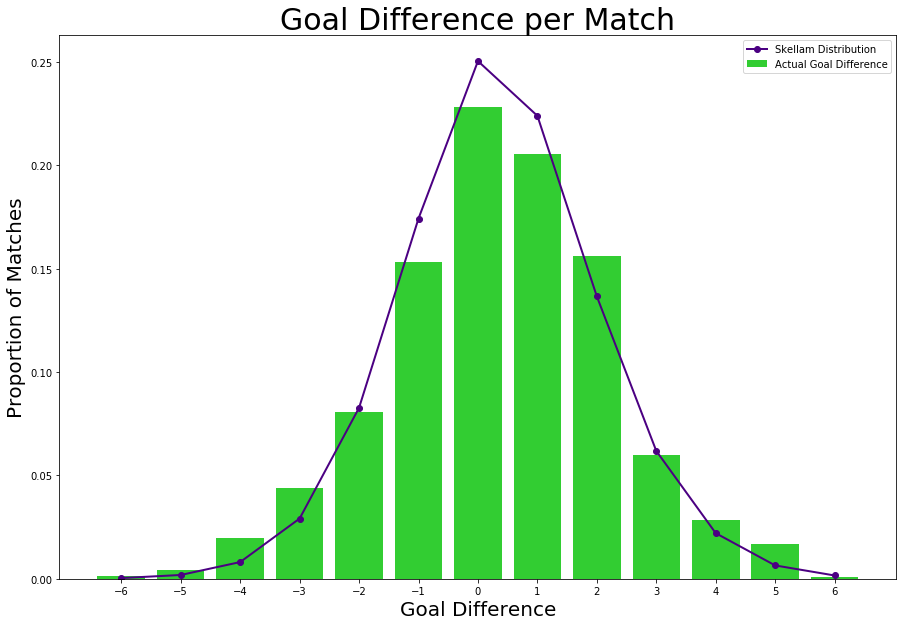

In [23]:
# Now that we have the values, we can plot the skellam distribution

fig, ax = plt.subplots(figsize = [15, 10])
# Since we are taking a difference in the means, we need the actual differences in goal scored.  We already have a
# column in pl_df that calculated the goal difference so we will again take the proportion.
actual = ax.bar(plot_values.iloc[:,0], plot_values.iloc[:,1], label = 'Actual Goal Difference', color = 'limegreen')

# Now we can add the skellam pmf values
skel = ax.plot(plot_values.iloc[:,0], plot_values.iloc[:,2], marker = 'o', color = 'indigo', linewidth = 2,\
                            label = 'Skellam Distribution')

ax.set_ylabel('Proportion of Matches', fontsize = 20)
ax.set_xlabel('Goal Difference', fontsize = 20)
ax.set_title('Goal Difference per Match', fontsize = 30)
ax.set_xticks(plot_values['GD'])
ax.legend()
plt.show()

As you can see from the plot above, we have a perfect case of a skellam distribution since the difference between the two means at every goal is a binomial distribution.  When we entered the skellam.pmf function values to this plot, the probabilities of each event (goal difference) occuring is very close to the actual values.  We can therefore use the poisson regression to model and predict outcomes.

# Modelling

In [24]:
# We will use statsmodels package to conduct a Poisson Regression Model
import statsmodels.api as sm
import statsmodels.formula.api as smf

Before we can begin modelling, we need to create a dataframe that will allow the model to digest the information.
These changes are standard when fitting the Poisson model.  The HomeTeam and AwayTeam features are categorical so we need to assign a numerical value to each so that the model will fit to the correct teams.

In [25]:
# Create a dataframe for the home team where we will then assign a 1
home_poisson = pl_train[['HomeTeam', 'AwayTeam', 'score1', 'HomeSPI', 'HomeImportance', 'HomeShotXPG', 'HomeNonShotXPG']]

# Create a new column that will assign a '1' to the HomeTeam
home_poisson = home_poisson.assign(home = 1)

# Rename the columns
home_poisson = home_poisson.rename(columns = {'HomeTeam':'team', 'AwayTeam':'opponent', 'score1':'goals',\
                                              'HomeSPI':'spi', 'HomeImportance':'importance', 'HomeShotXPG':'shotxpg',\
                                              'HomeNonShotXPG':'nonshotxpg'})

home_poisson

,team,opponent,goals,spi,importance,shotxpg,nonshotxpg,home
0,Hull City,Leicester City,2.0,53.57,38.1,0.85,0.17,1
1,Crystal Palace,West Bromwich Albion,0.0,55.19,43.6,1.11,0.84,1
2,Everton,Tottenham Hotspur,1.0,68.02,31.9,0.73,0.88,1
3,Middlesbrough,Stoke City,1.0,56.32,33.9,1.40,1.13,1
4,Burnley,Swansea City,0.0,58.98,36.5,1.24,1.71,1
...,...,...,...,...,...,...,...,...
1333,West Ham United,Leicester City,1.0,65.09,41.4,1.06,1.88,1
1334,Norwich City,Tottenham Hotspur,2.0,60.16,34.1,0.27,0.52,1
1335,Burnley,Manchester United,0.0,70.38,15.3,0.64,1.04,1
1336,Arsenal,Chelsea,1.0,75.90,13.1,0.86,1.37,1


In [26]:
# Create a dataframe for the home team where we will then assign a 1
away_poisson = pl_train[['AwayTeam', 'HomeTeam', 'score2', 'AwaySPI', 'AwayImportance', 'AwayShotXPG', 'AwayNonShotXPG']]

# Create a new column that will assign a '1' to the HomeTeam
away_poisson = away_poisson.assign(home = 0)

# Rename the columns so that the AwayTeam is now the 'team' and the HomeTeam is now the 'opponent'
away_poisson = away_poisson.rename(columns = {'AwayTeam':'team', 'HomeTeam':'opponent', 'score2':'goals',\
                                              'AwaySPI':'spi', 'AwayImportance':'importance',\
                                              'AwayShotXPG':'shotxpg','AwayNonShotXPG':'nonshotxpg'})

away_poisson

,team,opponent,goals,spi,importance,shotxpg,nonshotxpg,home
0,Leicester City,Hull City,1.0,66.81,22.2,2.77,1.25,0
1,West Bromwich Albion,Crystal Palace,1.0,58.66,34.6,0.68,1.60,0
2,Tottenham Hotspur,Everton,1.0,73.25,48.0,1.11,1.81,0
3,Stoke City,Middlesbrough,1.0,60.35,32.5,0.55,1.06,0
4,Swansea City,Burnley,1.0,59.74,29.1,1.84,1.56,0
...,...,...,...,...,...,...,...,...
1333,Leicester City,West Ham United,2.0,80.89,52.2,2.54,1.58,0
1334,Tottenham Hotspur,Norwich City,2.0,82.00,61.4,1.99,1.96,0
1335,Manchester United,Burnley,2.0,80.80,39.5,2.17,1.22,0
1336,Chelsea,Arsenal,2.0,85.40,71.0,1.67,1.43,0


In [27]:
# Concatenate the two dataframes together.
pl_poi = pd.concat([home_poisson, away_poisson])

pl_poi

,team,opponent,goals,spi,importance,shotxpg,nonshotxpg,home
0,Hull City,Leicester City,2.0,53.57,38.1,0.85,0.17,1
1,Crystal Palace,West Bromwich Albion,0.0,55.19,43.6,1.11,0.84,1
2,Everton,Tottenham Hotspur,1.0,68.02,31.9,0.73,0.88,1
3,Middlesbrough,Stoke City,1.0,56.32,33.9,1.40,1.13,1
4,Burnley,Swansea City,0.0,58.98,36.5,1.24,1.71,1
...,...,...,...,...,...,...,...,...
1333,Leicester City,West Ham United,2.0,80.89,52.2,2.54,1.58,0
1334,Tottenham Hotspur,Norwich City,2.0,82.00,61.4,1.99,1.96,0
1335,Manchester United,Burnley,2.0,80.80,39.5,2.17,1.22,0
1336,Chelsea,Arsenal,2.0,85.40,71.0,1.67,1.43,0


In [28]:
pl_poi.columns

Index(['team', 'opponent', 'goals', 'spi', 'importance', 'shotxpg',
       'nonshotxpg', 'home'],
      dtype='object')

How do we read our newly created dataframe?

- We see that we have double the number of rows than our initial dataset.  In order for our model to pull the information, it needs to know how the home team and away team are going to be.  It is for this reason that we created the new 'home' feature that will allow the model to know who the home team is and to pull the correct goals scored from the goals feature.  If the team is the home team, denoted by '1', then it will take the goals from the column next to it and if it's the away team, it will take the goals where home is denoted a '0'. For example, we see that Aston Villa is the home team so the model will associated 0 goals to then whereas the away team is denoted as the '0' and will associated 2 goals to them.
- Essentially we have 1338 rows where the home team is the 'team' and another 1338 rows where the away team is the 'team'.

In [29]:
# Now we can model the dataframe

# Write the formula that we will be entering into the model
formula = 'goals ~ home + spi + importance + shotxpg + nonshotxpg + team + opponent'

# Instantiate the model
pl_pm = smf.glm(formula = formula, data = pl_poi, family = sm.families.Poisson())

# Fit the model
pl_pm = pl_pm.fit()

# Get a summary of the model
pl_pm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2676
Model:                            GLM   Df Residuals:                     2614
Model Family:                 Poisson   Df Model:                           61
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3548.7
Date:                Fri, 27 Mar 2020   Deviance:                       2338.2
Time:                        14:52:31   Pearson chi2:                 1.96e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.1120      0.262     -0.428      0.669      -0.625       0.401
team[T.Arsenal]                          0.2843      0.126      2.250      0.024       0.037       0.532
team[T.Aston Villa]                     -0.0926      0.218     -0.425      0.671      -0.520       0.334
team[T.Brighton and Hove Albion]        -0.1954      0.130     -1.504      0.133      -0.450       0.059
team[T.Burnley]                         -0.1165      0.113     -1.030      0.303      -0.338       0.105
team[T.Cardiff City]                    -0.2788      0.190     -1.466      0.143      -0.651       0.094
team[T.Chelsea]                          0.2758      0.136      2.020      0.043       0.008       0.543
team[T.Crystal Palace]                  -0.0509      0.109     -0.466      0.641      -0.265       0.163
team[T.Everton]                          0.0184      0.108      0.170      0.865      -0.194       0.231
team[T.Fulham]                          -0.2596      0.189     -1.376      0.169      -0.629       0.110
team[T.Huddersfield Town]               -0.4522      0.166     -2.719      0.007      -0.778      -0.126
team[T.Hull City]                       -0.1374      0.191     -0.720      0.471      -0.511       0.236
team[T.Leicester City]                   0.0679      0.107      0.637      0.524      -0.141       0.277
team[T.Liverpool]                        0.2695      0.141      1.908      0.056      -0.007       0.546
team[T.Manchester City]                  0.2726      0.151      1.800      0.072      -0.024       0.569
team[T.Manchester United]                0.0947      0.127      0.744      0.457      -0.155       0.344
team[T.Middlesbrough]                   -0.4505      0.210     -2.140      0.032      -0.863      -0.038
team[T.Newcastle]                       -0.1661      0.126     -1.318      0.187      -0.413       0.081
team[T.Norwich City]                    -0.0226      0.234     -0.097      0.923      -0.480       0.435
team[T.Sheffield United]                -0.1091      0.223     -0.489      0.625      -0.547       0.328
team[T.Southampton]                     -0.1995      0.113     -1.766      0.077      -0.421       0.022
team[T.Stoke City]                      -0.1446      0.138     -1.045      0.296      -0.416       0.127
team[T.Sunderland]                      -0.3852      0.207     -1.864      0.062      -0.790       0.020
team[T.Swansea City]                    -0.1600      0.144     -1.114      0.265      -0.441       0.121
team[T.Tottenham Hotspur]                0.1932      0.129      1.495      0.135      -0.060       0.447
team[T.Watford]                         -0.0546      0.111     -0.491      0.624      -0.273       0.164
team[T.West Bromwich Albion]          

###### Great! We have our model that we will be able to pass into a function (below) but what do these numbers represent?  We should be mostly concerned with the coefficients for now.

- The coefficients with 'team' is the offensive strength for that team.
- Positive values suggest that we expect the team to score more goals.
- Values closer to 0 suggest that we expect observations to be closer a draw.
- Negative values suggest that we expect the team to score less goals.
- The 'home' coefficient represents home field advantage which is a real feature in itself.  It is well known that teams playing at home have a higher likelihood of scoring goals and thus winning games.  In this case, the coefficient is 0.2695 which means that the team is 1.31 times more likely to score a goal (e is the mathematical constant from the poisson distribution function - e^0.2695).
- If we take an example of two teams, Liverpool and Everton, we see that the offensive strength is 0.2695 and 0.0184 respectively.  Consequently, Liverpool is more likely to score on average than Everton.
- The coefficients with 'opponent' is the defensive strength for a team.  Smaller and negative values suggests that it is more difficult to score against a team.
- If we take the same two teams, Liverpool and Everton, we see that the defensive strength is -0.4408 and -0.1827 respectively.  Consequently, it is more difficult to score against Liverpool than Everton.

**Theses are not probabilities.  We will calculate the probabilities below.**

Now that we have our model, we can begin predicting outcomes for games.  We will have to create a function where we can pass the model, the home team, the away team and the maximum number of goals.  We expect to see the probability of each goal scored to decrease as the number of goals increases.

In [150]:
def simulation(pl_pm, HomeTeam, AwayTeam, max_goals = 8):
    # We use the .predict method to predict the average number of goals scored by each team.
    # We take the data from the dataframe that we created and rename the columns.  The identifier for the home team
    # will be a 1 or a 0 so that the simulation function knows which to assign the home advantage coefficient.
    # We also add in all the other features(spi, importance, shotxpg, nonshotxpg)
    avg_goals_home = pl_pm.predict(pd.DataFrame(data = {'team':HomeTeam, 'opponent':AwayTeam,\
                                                        'spi':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['HomeSPI'].tail(1),\
                                                        'importance':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['HomeImportance'].tail(1),\
                                                        'shotxpg':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['HomeShotXPG'].tail(1),\
                                                        'nonshotxpg':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['HomeNonShotXPG'].tail(1),\
                                                        'home':1})).values[0]
    avg_goals_away = pl_pm.predict(pd.DataFrame(data = {'team':AwayTeam, 'opponent':HomeTeam,\
                                                        'spi':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['AwaySPI'].tail(1),\
                                                        'importance':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['AwayImportance'].tail(1),\
                                                        'shotxpg':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['AwayShotXPG'].tail(1),\
                                                        'nonshotxpg':pl_train[(pl_train['HomeTeam'] == HomeTeam) & (pl_train['AwayTeam'] == AwayTeam)]['AwayNonShotXPG'].tail(1),\
                                                        'home':0})).values[0]
    
    # We use the poisson.pmf from the poisson distribution which will calculate the the probabilities for each goal in
    # the range specified.  This will in turn run through a for loop of the simulation and the probabilities of each
    # scoreline
    predictions = [[poisson.pmf(g, avg_goals) for g in range(0, max_goals+1)] 
                   for avg_goals in [avg_goals_home, avg_goals_away]]
    
    # We take all of those probabilities and return a matrix where the columns represent the home team goal probs and
    # the rows are the away team goal probs
    return(pd.DataFrame(np.outer(np.array(predictions[1]), np.array(predictions[0]))))

In [152]:
# If we run our two teams into the function, we get a dataframe of the probabilities for each team scoring 
# max_goals = n.  In this case we put a maximum of 6 goals as anything more is highly unlikely.
simulation(pl_pm, 'Liverpool', 'Everton', max_goals = 8)

,0,1,2,3,4,5,6,7,8
0,0.020752,0.057031,0.078365,0.071787,0.049321,0.027108,1.241646e-02,4.874658e-03,1.674552e-03
1,0.023386,0.064269,0.088312,0.080899,0.055581,0.030549,1.399248e-02,5.493399e-03,1.887103e-03
2,0.013177,0.036214,0.049761,0.045584,0.031318,0.017213,7.884271e-03,3.095338e-03,1.063317e-03
3,0.004950,0.013603,0.018692,0.017123,0.011764,0.006466,2.961674e-03,1.162743e-03,3.994278e-04
4,0.001395,0.003833,0.005266,0.004824,0.003314,0.001822,8.343998e-04,3.275825e-04,1.125318e-04
5,0.000314,0.000864,0.001187,0.001087,0.000747,0.000411,1.880620e-04,7.383251e-05,2.536309e-05
6,0.000059,0.000162,0.000223,0.000204,0.000140,0.000077,3.532212e-05,1.386734e-05,4.763738e-06
7,0.000010,0.000026,0.000036,0.000033,0.000023,0.000012,5.686509e-06,2.232504e-06,7.669142e-07
8,0.000001,0.000004,0.000005,0.000005,0.000003,0.000002,8.010371e-07,3.144844e-07,1.080323e-07


As you can see, this matrix shows the probabilities of each goal and score occuring between Liverpool and Everton.  The home team goals are represented in the columns while the away team goals are represented in the rows.  When the score is a draw (same goals for both home and away), the probabilities are found in the diagonal of the dataframe.

To get the probabilities of a win for the home team, a draw, and a win for the away team, we must add all of probabilities together.  We can write a function that will allow us to see the match probability outcomes.

In [69]:
def match_outcome(HomeTeam, AwayTeam):
    # For home win, takes the sum of the upper triangle of the array
    home_win = np.sum(np.triu(simulation(pl_pm, HomeTeam, AwayTeam, max_goals = 8), 1))
    
    # For a draw, takes the sum of the diagonal values in the array
    draw = np.sum(np.diag(simulation(pl_pm, HomeTeam, AwayTeam, max_goals = 8)))
    
    # For away win, takes the sum of the lower triangle of the array
    away_win = np.sum(np.tril(simulation(pl_pm, HomeTeam, AwayTeam, max_goals = 8), -1))
    
    return(home_win, draw, away_win)   

In [155]:
match_outcome('Liverpool', 'Everton')

(0.7116064799755815, 0.15566802545501782, 0.13057116909937855)

In [38]:
# Looking at the dataframe, the index is still pulling from when we initially sliced into our train and test set.
pl_test.head(5)

,Date,HomeTeam,AwayTeam,HomeSPI,AwaySPI,HomeWinProb,AwayWinProb,TieProb,HomeProjScore,AwayProjScore,HomeImportance,AwayImportance,score1,score2,HomeShotXPG,AwayShotXPG,HomeNonShotXPG,AwayNonShotXPG,HomeAdjScore,AwayAdjScore
1338,2019-12-29,Manchester City,Sheffield United,94.53,71.91,0.8507,0.0398,0.1095,2.82,0.48,13.6,13.6,2.0,0.0,1.22,1.21,1.27,0.76,1.80,0.00
1339,2020-01-01,Burnley,Aston Villa,69.44,61.33,0.4966,0.2524,0.2510,1.65,1.10,27.5,50.8,1.0,2.0,2.49,1.43,2.11,1.35,1.05,2.10
1340,2020-01-01,Brighton and Hove Albion,Chelsea,70.31,85.74,0.2215,0.5452,0.2334,1.10,1.85,18.1,66.3,1.0,1.0,1.74,1.39,2.08,1.32,1.05,1.05
1341,2020-01-01,Watford,Wolverhampton,69.87,78.66,0.3680,0.3540,0.2780,1.26,1.23,50.6,31.5,2.0,1.0,1.08,1.29,1.53,0.92,2.10,1.05
1342,2020-01-01,Southampton,Tottenham Hotspur,68.97,82.24,0.2711,0.4950,0.2339,1.31,1.84,26.2,52.0,1.0,0.0,1.31,1.18,1.14,1.25,1.05,0.00


In [119]:
pl_test.shape

(78, 20)

In [120]:
# Reset the index
pl_test = pl_test.reset_index(drop = True)

In [121]:
pl_test.head(5)

,Date,HomeTeam,AwayTeam,HomeSPI,AwaySPI,HomeWinProb,AwayWinProb,TieProb,HomeProjScore,AwayProjScore,HomeImportance,AwayImportance,score1,score2,HomeShotXPG,AwayShotXPG,HomeNonShotXPG,AwayNonShotXPG,HomeAdjScore,AwayAdjScore
0,2019-12-29,Manchester City,Sheffield United,94.53,71.91,0.8507,0.0398,0.1095,2.82,0.48,13.6,13.6,2.0,0.0,1.22,1.21,1.27,0.76,1.80,0.00
1,2020-01-01,Burnley,Aston Villa,69.44,61.33,0.4966,0.2524,0.2510,1.65,1.10,27.5,50.8,1.0,2.0,2.49,1.43,2.11,1.35,1.05,2.10
2,2020-01-01,Brighton and Hove Albion,Chelsea,70.31,85.74,0.2215,0.5452,0.2334,1.10,1.85,18.1,66.3,1.0,1.0,1.74,1.39,2.08,1.32,1.05,1.05
3,2020-01-01,Watford,Wolverhampton,69.87,78.66,0.3680,0.3540,0.2780,1.26,1.23,50.6,31.5,2.0,1.0,1.08,1.29,1.53,0.92,2.10,1.05
4,2020-01-01,Southampton,Tottenham Hotspur,68.97,82.24,0.2711,0.4950,0.2339,1.31,1.84,26.2,52.0,1.0,0.0,1.31,1.18,1.14,1.25,1.05,0.00


In [156]:
def simulate(pl_pm, HomeTeam, AwayTeam, max_goals):
    # We use the .predict method to predict the average number of goals scored by each team.
    # We take the data from the dataframe that we created and rename the columns.  The identifier for the home team
    # will be a 1 or a 0 so that the simulation function knows which to assign the home advantage coefficient.
    avg_goals_home = pl_pm.predict(pd.DataFrame(data = {'team':HomeTeam, 'opponent':AwayTeam,\
                                                        'spi':pl_poi[(pl_poi['team'] == HomeTeam) & (pl_poi['opponent'] == AwayTeam)]['spi'].tail(1),\
                                                        'importance':pl_poi[(pl_poi['team'] == HomeTeam) & (pl_poi['opponent'] == AwayTeam)]['importance'].tail(1),\
                                                        'shotxpg':pl_poi[(pl_poi['team'] == HomeTeam) & (pl_poi['opponent'] == AwayTeam)]['shotxpg'].tail(1),\
                                                        'nonshotxpg':pl_poi[(pl_poi['team'] == HomeTeam) & (pl_poi['opponent'] == AwayTeam)]['nonshotxpg'].tail(1),\
                                                        'home':1})).values
    avg_goals_away = pl_pm.predict(pd.DataFrame(data = {'team':AwayTeam, 'opponent':HomeTeam,\
                                                        'spi':pl_poi[(pl_poi['team'] == AwayTeam) & (pl_poi['opponent'] == HomeTeam)]['spi'].tail(1),\
                                                        'importance':pl_poi[(pl_poi['team'] == AwayTeam) & (pl_poi['opponent'] == HomeTeam)]['importance'].tail(1),\
                                                        'shotxpg':pl_poi[(pl_poi['team'] == AwayTeam) & (pl_poi['opponent'] == HomeTeam)]['shotxpg'].tail(1),\
                                                        'nonshotxpg':pl_poi[(pl_poi['team'] == AwayTeam) & (pl_poi['opponent'] == HomeTeam)]['nonshotxpg'].tail(1),\
                                                        'home':0})).values
    
    predictions = [[poisson.pmf(g, avg_goals) for g in range(0, max_goals+1)] 
                   for avg_goals in [avg_goals_home, avg_goals_away]]
    
    return(np.outer(np.array(predictions[1]), np.array(predictions[0])))

In [103]:
# Create empty lists that will hold all of their respective values
HomeTeam = []
AwayTeam = []
HomePredGoals = []
AwayPredGoals = []
HomeActGoals = []
AwayActGoals = []

In [142]:
# Create a for loop that will run the simulation and append the correct values into their respective lists

for i in range(len(pl_test)):
    # enter the home team and away team
    preds = simulate(pl_pm, pl_test['HomeTeam'][i], pl_test['AwayTeam'][i], 6)
    # Remember that the predictions in the simulate function will now return an array of the probabilities
    # so in order to get the best score line, we will pass the argument:
        # argmax will return the index of the highest value according to the shape of the dataframe (all are 10x10)
        # because the max_goals is set to 9 (ie. 0-9).
    if len(preds) != 0:
        max_indices = np.unravel_index(preds.argmax(), preds.shape)

        # Append the home and away team names of the test set into the empty lists
        HomeTeam.append(pl_test['HomeTeam'][i])
        AwayTeam.append(pl_test['AwayTeam'][i])

        # Append the predicted home and away goals for both teams of the test set
        HomePredGoals.append(max_indices[1])
        AwayPredGoals.append(max_indices[0])

        # Append the actual home and way goals for both teams of the test set
        HomeActGoals.append(pl_test['score1'][i])
        AwayActGoals.append(pl_test['score2'][i])

# And we can now consolidate these lists into a dataframe

goals_df = pd.DataFrame({'Home Team': HomeTeam, 'Away Team': AwayTeam, 'Home Predicted Goals':HomePredGoals,\
                         'Away Predicted Goals': AwayPredGoals, 'Home Actual Goals':HomeActGoals,\
                         'Away Actual Goals':AwayActGoals})

In [143]:
def transformer(dataframe):
    # Get the results of the actual game and assign the result: H = Home Win, D = Draw, A = Away Win
    dataframe.loc[(dataframe['Home Actual Goals'] > dataframe['Away Actual Goals']), 'Result'] = 'H'
    dataframe.loc[(dataframe['Home Actual Goals'] == dataframe['Away Actual Goals']), 'Result'] = 'D'
    dataframe.loc[(dataframe['Home Actual Goals'] < dataframe['Away Actual Goals']), 'Result'] = 'A'
    
    # Get the results of the predicted simulation and assign a result: H = Home Win, D = Draw, A = Away Win
    dataframe.loc[(dataframe['Home Predicted Goals'] > dataframe['Away Predicted Goals']), 'PredictedResult'] = 'H'
    dataframe.loc[(dataframe['Home Predicted Goals'] == dataframe['Away Predicted Goals']), 'PredictedResult'] = 'D'
    dataframe.loc[(dataframe['Home Predicted Goals'] < dataframe['Away Predicted Goals']), 'PredictedResult'] = 'A'
    
    # Now we have to account if there is a PERFECT result.  That is to say the actual goals scored by the home and
    # away team is the exact same as the predicted goals scored by both teams.
    dataframe['Perfect Match'] = 'No'
    dataframe.loc[(dataframe['Home Actual Goals'] == dataframe['Home Predicted Goals']) &\
                  (dataframe['Away Actual Goals'] == dataframe['Away Predicted Goals']), 'Perfect Match'] = 'Yes'
    
    # Finally we can pass through if the the result from the actual game and the predicted simulation are equal.
    # This will give us a match to see how well we predicted the outcome
    dataframe.loc[dataframe['Result'] == dataframe['PredictedResult'], 'Correctly Predicted'] = 'Yes'
    dataframe.loc[dataframe['Result'] != dataframe['PredictedResult'], 'Correctly Predicted'] = 'No'
    
    return dataframe

In [144]:
# Now we just input the goals_df dataframe into the transformer function which will spit out our evaluation table
transformer(goals_df)

,Home Team,Away Team,Home Predicted Goals,Away Predicted Goals,Home Actual Goals,Away Actual Goals,Result,PredictedResult,Perfect Match,Correctly Predicted
0,Burnley,Aston Villa,1,0,1.0,2.0,A,H,No,No
1,Brighton and Hove Albion,Chelsea,0,2,1.0,1.0,D,A,No,No
2,Watford,Wolverhampton,1,1,2.0,1.0,H,D,No,No
3,Southampton,Tottenham Hotspur,0,1,1.0,0.0,H,A,No,No
4,Newcastle,Leicester City,0,1,0.0,3.0,A,A,No,Yes
...,...,...,...,...,...,...,...,...,...,...
71,Brighton and Hove Albion,Crystal Palace,1,1,0.0,1.0,A,D,No,No
72,Newcastle,Burnley,1,1,0.0,0.0,D,D,No,Yes
73,West Ham United,Southampton,1,0,3.0,1.0,H,H,No,Yes
74,AFC Bournemouth,Chelsea,1,0,2.0,2.0,D,H,No,No


In [145]:
# All that is left to do is to do a count of the the values and divide by the entire dataframe.  We see that our model
# did horribly in predicting the actual score of the game.

perfectmatches = goals_df['Perfect Match'].value_counts()
perfectmatches

No     69
Yes     7
Name: Perfect Match, dtype: int64

In [146]:
# Let's check the ratio of the how well our model predicted the scores
perfectmatchesratio = (goals_df['Perfect Match'].value_counts())/len(goals_df)
perfectmatchesratio

No     0.907895
Yes    0.092105
Name: Perfect Match, dtype: float64

In [147]:
correctlypredicted = goals_df['Correctly Predicted'].value_counts()/len(goals_df)
correctlypredicted

No     0.539474
Yes    0.460526
Name: Correctly Predicted, dtype: float64

In [148]:
predicted = goals_df['PredictedResult'].value_counts()

predicted

H    28
A    24
D    24
Name: PredictedResult, dtype: int64

In [149]:
actual = goals_df['Result'].value_counts()

actual

H    36
D    21
A    19
Name: Result, dtype: int64